#### Summary:
This notebook goes through all the steps to run Pando on a cell type of interest. First we recreate inputs for Pando for mouse (mm10), thengenerate GRNs from single cell multimodal data for a cell type (both KPC and AKPC cells), make some summary plots, and export for further analyses in Cytoscape. I also have included a section to calculate TF activity by genotype (average activity x genotype gene expression) and visualize interesting results.

### Note: I had to make a conda env with very specific package versions to get this to run! See my environment build summary in this github issue: https://github.com/quadbio/Pando/issues/53

In [1]:
# Load Packages
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(BSgenome.Mmusculus.UCSC.mm10))
suppressMessages(library(tidyverse))
suppressMessages(library(GenomicRanges))
suppressMessages(library(Pando))
suppressMessages(library(chromVARmotifs))
suppressMessages(library(tidygraph))
suppressMessages(library(ggraph))
suppressMessages(library(ggrepel))

options(warn=-1)

# Set cell type of interest

In [2]:
celltype <- 'myCAF'
celltype_name <- 'myCAF'

# celltype <- 'iCAF'
# celltype_name <- 'iCAF'

# celltype <- 'EMT-like cells'
# celltype_name <- 'EMT-like'

# celltype <- 'Ductal cells'
# celltype_name <- 'ductal'

In [3]:
pando_dir <- '/nfs/lab/projects/mouse_pdac/outputs/pando/final_grns'

# Prepare Pando Inputs

## Read in Seurat object, subset to cell type of interest and prep assays to use with Pando

In [4]:
#read in the object with the fixed peak atac data
rds_fp <- '/nfs/lab/projects/mouse_pdac/231203_2sample_merged_final_wFixedPeaks2.rds'
full_seurat_object <- readRDS(rds_fp)
full_seurat_object

An object of class Seurat 
958079 features across 10445 samples within 6 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 5 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [5]:
#subset down to cell type of interest
seurat_object <- subset(full_seurat_object, Fibroblasts == celltype)
seurat_object

An object of class Seurat 
958079 features across 464 samples within 6 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 5 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [6]:
#remove any data from Rik genes (all proceeded by a number which causes pando to error)
counts <- GetAssayData(seurat_object, assay='RNA', slot='counts')
counts_cut <- counts[!grepl('Rik',row.names(counts)),]
seurat_object[["RNAcut"]] <- CreateAssayObject(counts=counts_cut)

In [7]:
#make sure data is properly normalized (RNA should be log-normalized and ATAC should be TF-IDF normalized)
DefaultAssay(seurat_object) <- 'RNAcut'
seurat_object <- NormalizeData(seurat_object, normalization.method="LogNormalize")

DefaultAssay(seurat_object) <- 'FixPeaks'
seurat_object <- RunTFIDF(seurat_object, assay='FixPeaks')

Performing TF-IDF normalization



In [8]:
#select variable features for the RNA assay
seurat_object <- Seurat::FindVariableFeatures(seurat_object, assay='RNAcut')

### Read in necessary references

In [9]:
# Get motif data -- read in mouse mm10 motif objects
fp1 <- '/nfs/lab/projects/mouse_pdac/references/CISBP_motif_info_mus_musculus/chromVARmotifs_mouse_pwms_v2_cut2.rds'
fp2 <- '/nfs/lab/projects/mouse_pdac/references/CISBP_motif_info_mus_musculus/motif2tf_mouse_cut2.txt'
mouse_pwm <- readRDS(fp1)
mouse_motif2tf <- read.table(fp2, sep='\t', header=TRUE)

In [10]:
# Read in SCREEN V3 mm10 regions (GRanges object made from a downloaded bed file)
screen_fp <- '/nfs/lab/projects/mouse_pdac/references/SCREEN_V3_mm10/SCREEN_V3_mm10-cCREs.rds'
screen.mm10 <- readRDS(screen_fp)

# Make a GRN with Pando

## Initiate GRN

In [11]:
# Initiate GRN object and select candidate regions -- tell it which peak assay to use
# include SCREEN cCREs to cut down cRE input set (runs faster and more relevant)
seurat_object <- initiate_grn(seurat_object, peak_assay='FixPeaks', rna_assay='RNAcut', regions=screen.mm10)
seurat_object

An object of class SeuratPlus 
987832 features across 464 samples within 7 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 6 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks, RNAcut
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

## Find Motifs

In [12]:
# Scan candidate regions for TF binding motifs -- use with mouse genome
seurat_object <- find_motifs(
    seurat_object,
    pfm = mouse_pwm, 
    motif_tfs = mouse_motif2tf,
    genome = BSgenome.Mmusculus.UCSC.mm10
)
seurat_object

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object



An object of class SeuratPlus 
987832 features across 464 samples within 7 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 6 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks, RNAcut
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

## Infer GRN

In [13]:
# Infer gene regulatory network 
seurat_object <- infer_grn(seurat_object, peak_to_gene_method='Signac', method='glm')
seurat_object

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 1811 target genes



An object of class SeuratPlus 
987832 features across 464 samples within 7 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 6 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks, RNAcut
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

## GetGRN

In [14]:
GetGRN(seurat_object)

A RegulatoryNetwork object based on 752 transcription factors
1 inferred network: glm_network

In [15]:
#find TF modules -- relaxed thresholds
seurat_object <- find_modules(
    seurat_object, 
    p_thresh = 0.1,
    nvar_thresh = 2, 
    min_genes_per_module = 1,
    rsq_thresh = 0.05
)

Found 472 TF modules



In [16]:
#save out object
rds_fp <- file.path(pando_dir, sprintf('240117_pando_%s_seurat_plus.rds',celltype_name))
rds_fp
saveRDS(seurat_object, rds_fp)

[1] "/nfs/lab/projects/mouse_pdac/outputs/pando/final_grns/240117_pando_myCAF_seurat_plus.rds"

# Make summary plots of Pando GRN results

## Optional: start notebook here and read in from RDS

In [17]:
#read in object
rds_fp <- file.path(pando_dir, sprintf('240117_pando_%s_seurat_plus.rds',celltype_name))
seurat_object <- readRDS(rds_fp)

In [18]:
seurat_object

An object of class SeuratPlus 
987832 features across 464 samples within 7 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 6 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks, RNAcut
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

## Plots

In [19]:
plot_dir <- file.path(pando_dir, 'plots')

In [20]:
#make the goodness of fit plot (for each TF tested: R^2 vs # target genes)
p1 <- plot_gof(seurat_object, point_size=3) + ggtitle(celltype) + 
          theme(plot.title = element_text(face = "bold", size = (15)))

#save as png and svg
fp1 <- file.path(plot_dir,sprintf('%s_pando_GRN_gof.png',celltype_name))
ggsave(fp1, p1, device='png', width=6, height=6, units='in')   

fp1 <- gsub('png','svg', fp1)
ggsave(fp1, p1, device='svg', width=6, height=6, units='in')

In [21]:
#make the module metrics plot (how many genes/regions/tfs etc)
p2 <- plot_module_metrics(seurat_object) + labs(subtitle=celltype) + 
          theme(plot.subtitle = element_text(face = "bold", size = (15)))

#save as png and svg
fp2 <- file.path(plot_dir,sprintf('%s_pando_GRN_summary_metrics.png',celltype_name))
ggsave(fp2, p2, device='png', width=6, height=4, units='in')

fp2 <- gsub('png','svg',fp2)
ggsave(fp2, p2, device='svg', width=6, height=4, units='in')

# Calculate a network graph and write this and various metadata to tables

## Make a preliminary UMAP plot as a sanity check (and to organize network data)

In [22]:
#run get_network_graph to get a graph object for manipulation
seurat_object <- get_network_graph(seurat_object, graph_name='umap_graph', umap_method='corr')
plot_graph <- seurat_object@grn@networks$glm_network@graphs$umap_graph

Computing gene-gene correlation

Computing UMAP embedding

Getting network graph



In [23]:
#add in relevant metadata from the differential genotype tests
tfs <- as_tibble(plot_graph %>% activate(nodes))$name

#read in genotype differential results with rank values
diff_fp <- sprintf('/nfs/lab/projects/mouse_pdac/outputs/rna_findMarkers/celltype_markers/%s_celltype_markers.txt',celltype)
diff_df <- read.table(diff_fp, sep='\t', header=T)

#make metadata df
meta <- data.frame(name=tfs, diff_fc=diff_df[tfs,'avg_log2FC'], diff_pval=diff_df[tfs,'p_val'], diff_padj=diff_df[tfs,'p_val_adj'], diff_rank=diff_df[tfs,'rank'])

#add in TF metadata to the tbl_graph object with tidygraph
plot_graph <- plot_graph %>% activate(nodes) %>% left_join(meta)

Joining with `by = join_by(name)`


In [28]:
rank_cutoff <- 1
table(abs(as_tibble(plot_graph %>% activate(nodes))$diff_rank) > rank_cutoff)
plot_graph <- plot_graph %>% activate(nodes) %>% mutate(rank_clamp=pmax(pmin(diff_rank, rank_cutoff),-rank_cutoff))


FALSE  TRUE 
  645    35 

In [29]:
#only label a subset of genes
#label genes with largest absolute rank
node_info <- as_tibble(plot_graph %>% activate(nodes))
rank_genes <- node_info[abs(node_info$diff_rank) >= rank_cutoff,]$name
length(rank_genes)

[1] 35

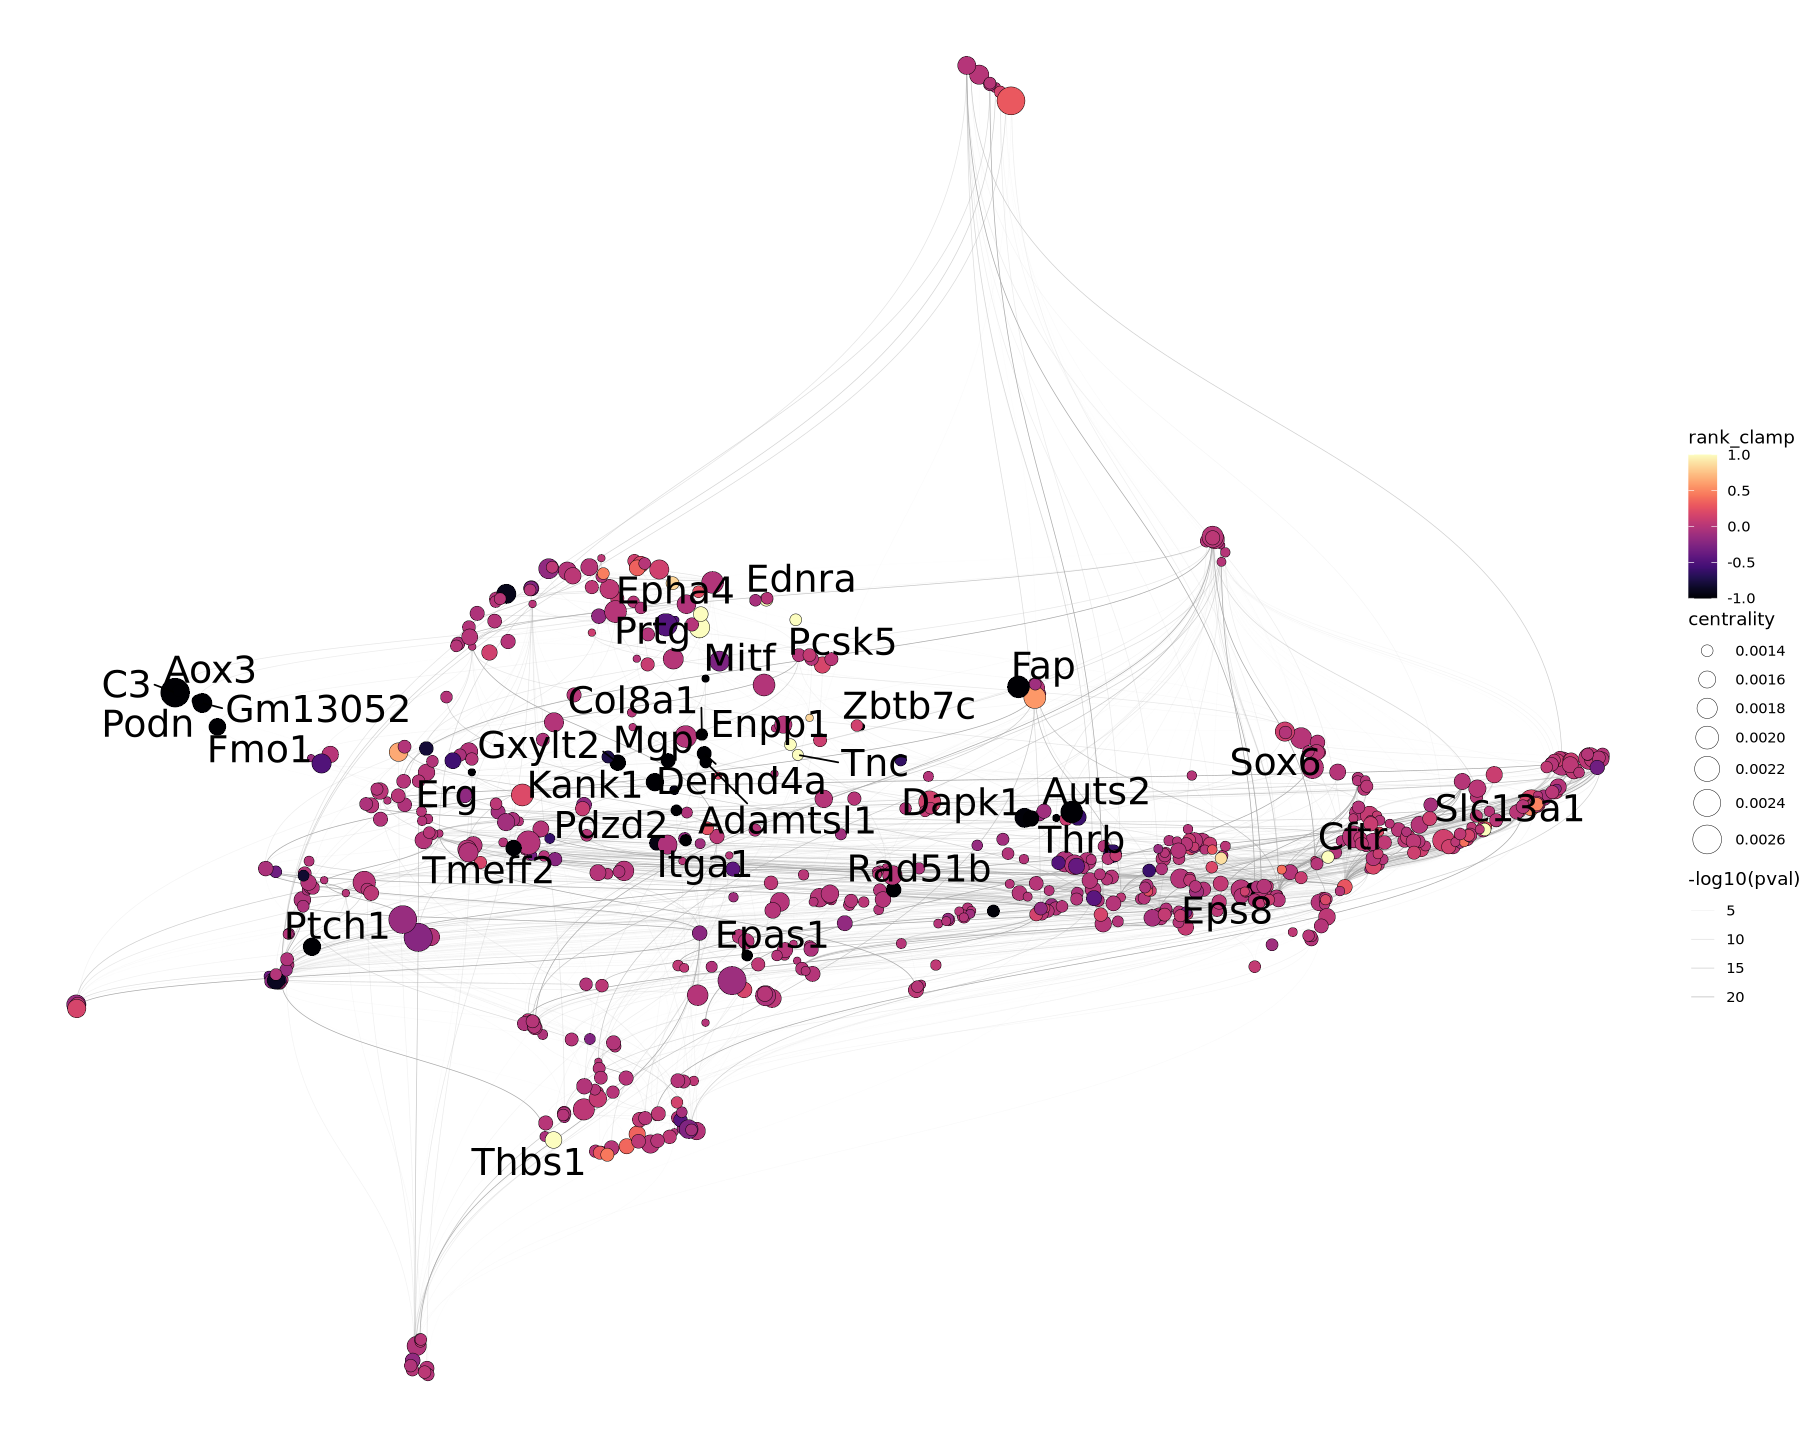

In [30]:
# Custom plotting code: color nodes by rank, size them by page rank, connections by p-value? (only include super sig connections?)
node_color = pals::magma(100)
text_size=8
node_size=c(2,8)

# Make plot!
options(repr.plot.width=15, repr.plot.height=12)
p <- ggraph(plot_graph, x=UMAP_1, y=UMAP_2) +
        geom_edge_diagonal(aes(alpha=-log10(pval)), color='dark gray', width=0.2) +
        scale_edge_alpha_continuous(range=c(0.01,0.8), limits=c(2,20)) +
        geom_node_point(aes(fill=rank_clamp, size=centrality), shape=21, stroke=0.2) +
        scale_fill_gradientn(colors=node_color) + 
        scale_size_continuous(range=node_size) +
        geom_node_text(aes(label=name, filter=(name %in% rank_genes)), size=text_size, max.overlaps=99999, repel=T) +
        theme(text=element_text(family='Arial')) + 
        theme_void()
p

## Write nodes and edges info to csv files

In [31]:
cytoscape_dir <- file.path(pando_dir, 'cytoscape_inputs')

In [32]:
#pull out node info from the tbl_graph object
nodes_df <- as.data.frame(plot_graph %>% activate(nodes))
nodes_df$node <- row.names(nodes_df)

#add in aditional info for genes in gene lists
#classify differential gene expression list ('KPC' or 'AKPC')
nodes_df$diff_category <- ifelse(nodes_df$diff_fc > 0, 'AKPC', ifelse(nodes_df$diff_fc < 0, 'KPC', 'Neither'))

# TGFb gene list (add category and source)
fp1 <- '/nfs/lab/projects/mouse_pdac/references/gene_sets/240103_TGFb_genes_fin.txt'
tgfb_genes_df <- read.table(fp1, sep='\t', header=1)
tgfb_genes_df <- tgfb_genes_df[,-4]
colnames(tgfb_genes_df) <- c('name','TGFb_category','TGFb_support')

#merge in TGFb info
nodes_df2 <- merge(x=nodes_df, y=tgfb_genes_df, by='name', all.x=TRUE, all.y=FALSE)

#resort by node number (move that to the first col too)
nodes_df_fin <- nodes_df2[order(as.numeric(nodes_df2$node)),] %>% relocate(node)
head(nodes_df_fin)

#write to file
nodes_fp <- file.path(cytoscape_dir, sprintf('%s_nodes_meta.csv',celltype_name))
write.table(nodes_df_fin, nodes_fp, sep='\t', row.names=FALSE, col.names=TRUE, quote=FALSE)

,node,name,centrality,UMAP_1,UMAP_2,diff_fc,diff_pval,diff_padj,diff_rank,rank_clamp,diff_category,TGFb_category,TGFb_support
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
21,1,Ahr,0.001350872,-0.5634794,0.4655485,0.1579683158,0.05103634,1,2.041141e-01,2.041141e-01,AKPC,target gene,MSigDB
32,2,Ar,0.001350872,-4.5795946,-1.6237171,-0.0923750923,0.21134824,1,-6.235331e-02,-6.235331e-02,KPC,NA,NA
41,3,Arnt2,0.001350872,2.4021916,1.4463973,-0.0066832601,0.69516643,1,-1.055362e-03,-1.055362e-03,KPC,"target gene,suppressed",MSigDB
64,4,Bcl11a,0.001412964,2.4353025,-0.9889904,-0.0001278362,0.82263864,1,-1.083934e-05,-1.083934e-05,KPC,NA,NA
65,5,Bcl11b,0.001452763,-4.6281243,-1.7551960,-0.0307368827,0.38827369,1,-1.262862e-02,-1.262862e-02,KPC,NA,NA
101,6,Cdx2,0.001350872,1.7892859,8.1558139,0.0084122398,0.39972748,1,3.350057e-03,3.350057e-03,AKPC,NA,NA


In [33]:
#pull out edge info
edges_df <- as.data.frame(plot_graph %>% activate(edges))

#add -log10pvalue column for easier edge coloring
edges_df$log10p <- -log10(edges_df$pval)
dim(edges_df)
head(edges_df)

#write to file
edges_fp <- file.path(cytoscape_dir, sprintf('%s_edges_meta.csv',celltype_name))
write.table(edges_df, edges_fp, sep='/t', row.names=FALSE, col.names=TRUE, quote=FALSE)

[1] 1143   14

,from,to,estimate,n_regions,n_genes,n_tfs,regions,pval,padj,corr,from_node,to_node,dir,log10p
,<int>,<int>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,1,70,0.3013485,1,2,1,chr18-24708490-24708703,1.106741e-03,1.584703e-02,0.1629609,Ahr,Fhod3,1,2.955954
2,1,71,0.1512444,3,2,3,chr6-113638267-113638466,6.204884e-03,6.661918e-02,0.1714793,Ahr,Irak2,1,2.207266
3,2,72,0.1009616,5,2,6,chr1-72229009-72229350,2.076662e-13,1.383485e-11,0.2457962,Ar,Mreg,1,12.682634
4,2,73,0.5269677,6,2,6,chr5-33104068-33104218,1.824249e-09,8.098411e-08,0.1538714,Ar,Slc5a1,1,8.738916
5,3,74,5.4751329,2,3,2,chr13-100595308-100595645,6.097340e-03,6.565636e-02,0.2669716,Arnt2,Ccdc125,1,2.214860
6,3,75,2.9517124,2,3,2,chr9-76016546-76016885,1.719646e-15,1.378227e-13,0.3078405,Arnt2,Hmgcll1,1,14.764561


# Calculate basic per TF summary metrics

In [34]:
#pull sig mods from object
mods <- seurat_object@grn@networks$glm_network@modules@meta
dim(mods)

#write to file
out_fp <- file.path(pando_dir, 'outputs', sprintf('%s_30k_subset_sig_mods.txt',celltype))
write.table(mods, out_fp, sep='\t', row.names=FALSE, quote=FALSE)

[1] 3218    9

In [40]:
#make per tf summary dataframe
out_df <- mods %>% group_by(tf)  %>% 
            mutate(sig_targets=paste(unique(target),collapse=',')) %>% 
            select(-c(target,estimate,n_regions,n_tfs,regions,pval,padj)) %>% distinct()

#add in basic gex data
out_df$tf_mean_counts_all <- rowMeans(seurat_object@assays$RNA@counts)[out_df$tf]

# read in differential gene expression data and add rank to summary df
diff_fp <- sprintf('/nfs/lab/projects/mouse_pdac/outputs/rna_findMarkers/celltype_markers/%s_celltype_markers.txt',celltype)
diff_df <- read.table(diff_fp, sep='\t', header=T)
diff_df$gene <- row.names(diff_df)
rank_df <- diff_df[,c(6,7)]
colnames(rank_df)[2] <- 'tf'
out_df <- out_df %>% left_join(rank_df, by='tf')

#final rearrange
colnames(out_df)[2] <- 'n_targets'
out_df <- out_df %>% relocate(c(n_targets, sig_targets), .after=rank)
head(out_df)

#write to file
out_fp2 <- file.path(pando_dir, 'outputs', sprintf('%s_30k_subset_perTF_summary.txt',celltype))
write.table(out_df, out_fp2, sep='\t', row.names=FALSE, quote=FALSE)

tf,tf_mean_counts_all,rank,n_targets,sig_targets
<chr>,<dbl>,<dbl>,<int>,<chr>
Ahctf1,0.80603448,0.001251244,3,"Col4a4,Slc12a2,Uck2"
Ahr,0.59267241,0.204114092,2,"Fhod3,Irak2"
Ahrr,0.01077586,-0.002638857,2,"Echdc2,Pou2f2"
Alx4,0.03663793,0.002088805,2,"Megf11,Tnfsf18"
Ar,0.57974138,-0.062353314,2,"Mreg,Slc5a1"
Arid2,1.69612069,-0.003748381,4,"B4galt6,Mpp7,Pdgfc,Tpd52"


# Print out sessionInfo

In [41]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/hmummey/.conda/envs/pando3/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.9.4                      ggraph_2.1.0                      
 [3] tidygraph_1.3.0                    chromVARmotifs_0.2.0              
 [5] Pando_1.0.5                        lubridate_1.9.3  